In [1]:
import matplotlib.pyplot as plt
import pandas as pd

In [2]:
pd.set_option('display.max_rows', None)  # display all rows.
pd.set_option('display.float_format', '{:.2f}'.format)  # two decimals.

%matplotlib inline

In [3]:
def get_all_data(method):
    data = pd.DataFrame()
    
    for experiment in range(1, 73):
        df = pd.read_csv(f"analysis/cache/{experiment}-{method}.csv")
        df["experiment"] = experiment
        
        data = data.append(df, ignore_index=True)

    return data.set_index(["experiment", "instance"])

In [4]:
heuristic = get_all_data("heuristic")
heuristic.head()

objective  instruction (# learners)  \
experiment instance                                        
1          1           4774.84                       611   
           2           4759.64                       606   
           3           4640.12                       611   
           4           4680.35                       588   
           5           4701.76                       611   

                     self-study (# learners)  activities (#)  
experiment instance                                           
1          1                             189              43  
           2                             194              43  
           3                             189              43  
           4                             212              43  
           5                             189              43

In [5]:
ilp = get_all_data("ilp")
ilp.head()

objective  instruction (# learners)  \
experiment instance                                        
1          1           4777.54                       611   
           2           4765.53                       608   
           3           4644.67                       613   
           4           4690.98                       590   
           5           4709.46                       616   

                     self-study (# learners)  activities (#)  
experiment instance                                           
1          1                             189              43  
           2                             192              43  
           3                             187              43  
           4                             210              43  
           5                             184              43

# Objectives

In [6]:
objectives = pd.DataFrame(index=heuristic.index)

objectives["ilp"] = ilp.objective
objectives["heuristic"] = heuristic.objective
objectives["percentage"] = 100 * (ilp.objective - heuristic.objective) / heuristic.objective

grouped = objectives.groupby("experiment")

In [7]:
# Sanity check: the heuristic can never perform better than the optimal
# values for each problem instance.
assert len(objectives[objectives.ilp < objectives.heuristic]) == 0

In [8]:
print("Average difference (%) between heuristic and ILP objectives:")
100 * (ilp.objective.sum() - heuristic.objective.sum()) / heuristic.objective.sum()

Average difference (%) between heuristic and ILP objectives:


0.6487416879025373

Text(0, 0.5, 'Experiments (#)')

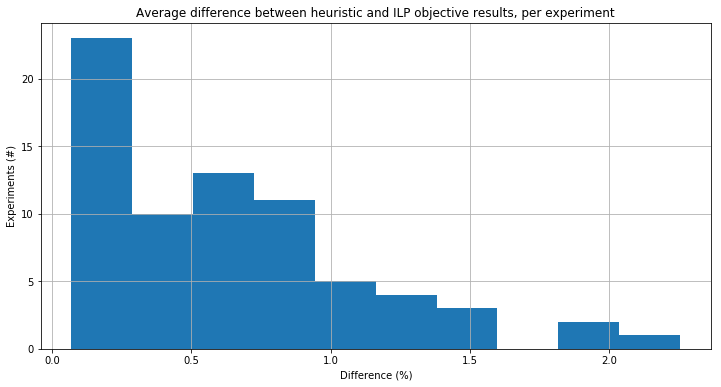

In [9]:
grouped.percentage.mean().hist(figsize=(12, 6))
plt.title("Average difference between heuristic and ILP objective results, per experiment")
plt.xlabel("Difference (%)")
plt.ylabel("Experiments (#)")

Text(0, 0.5, 'Experiments (#)')

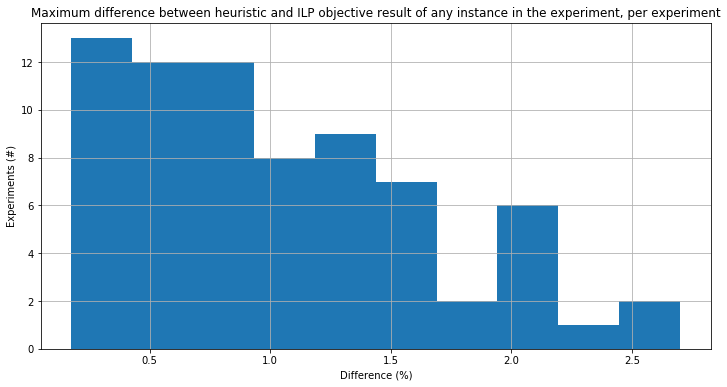

In [10]:
grouped.percentage.max().hist(figsize=(12, 6))
plt.title("Maximum difference between heuristic and ILP objective result of any instance in the experiment, per experiment")
plt.xlabel("Difference (%)")
plt.ylabel("Experiments (#)")

In [11]:
# This is used for the results table in the paper.
aggregates = grouped.aggregate({"ilp": "mean", "heuristic": "mean", "percentage": ["mean", "min", "max"]})
print(aggregates.to_latex(longtable=True, label="tab:heuristic_performance"))

\begin{longtable}{lrrrrr}
\label{tab:heuristic_performance}\\
\toprule
{} &     ilp & heuristic & \multicolumn{3}{l}{percentage} \\
{} &    mean &      mean &       mean &  min &  max \\
experiment &         &           &            &      &      \\
\midrule
\endhead
\midrule
\multicolumn{6}{r}{{Continued on next page}} \\
\midrule
\endfoot

\bottomrule
\endlastfoot
1          & 4726.15 &   4719.89 &       0.13 & 0.00 & 0.32 \\
2          & 4717.15 &   4711.47 &       0.12 & 0.01 & 0.27 \\
3          & 4720.07 &   4714.77 &       0.11 & 0.00 & 0.29 \\
4          & 4845.05 &   4835.82 &       0.19 & 0.05 & 0.32 \\
5          & 4853.04 &   4843.85 &       0.19 & 0.07 & 0.36 \\
6          & 4800.44 &   4788.20 &       0.26 & 0.09 & 0.48 \\
7          & 9773.15 &   9765.84 &       0.07 & 0.01 & 0.18 \\
8          & 9751.89 &   9745.08 &       0.07 & 0.01 & 0.19 \\
9          & 9751.20 &   9742.71 &       0.09 & 0.01 & 0.19 \\
10         & 9799.91 &   9741.24 &       0.60 & 0.46 & 0.73 \\
1

# Experimental results

In [12]:
experiments = pd.read_excel("experiments/experiments.xlsx")
experiments.set_index("experiment", inplace=True)

data = ilp.join(experiments)
data.head()

data["self-study (% learners)"] = data["self-study (# learners)"] 
data.loc[data.learners == 800, "self-study (% learners)"] /= 8
data.loc[data.learners == 1600, "self-study (% learners)"] /= 16

learners  progress
800       0          15.95
          1          49.48
          2          62.50
1600      0           5.30
          1          28.90
          2          45.50
Name: self-study (% learners), dtype: float64
learners  progress
800       0          127.63
          1          395.81
          2          500.02
1600      0           84.76
          1          462.38
          2          728.04
Name: self-study (# learners), dtype: float64


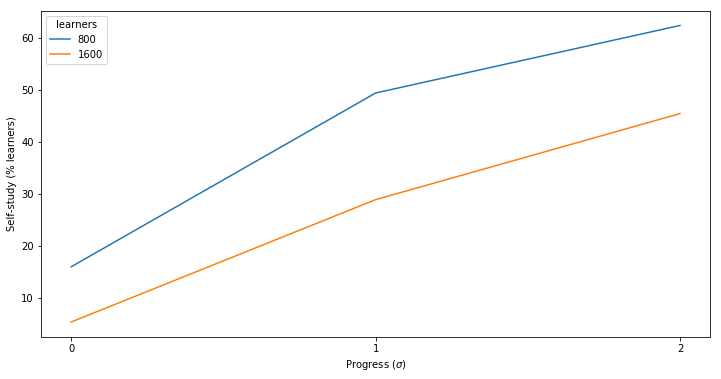

In [13]:
grouped = data.groupby(["learners", "progress"])
grouped["self-study (% learners)"].mean().unstack(0).plot(xticks=[0, 1, 2], figsize=(12, 6))

plt.xlabel("Progress ($\sigma$)")
plt.ylabel("Self-study (% learners)")

print(grouped["self-study (% learners)"].mean())
print(grouped["self-study (# learners)"].mean())

learners  penalty
800       1         47.55
          2         37.73
1600      1         30.76
          2         22.37
Name: self-study (% learners), dtype: float64
learners  penalty
800       1         380.43
          2         301.82
1600      1         492.20
          2         357.92
Name: self-study (# learners), dtype: float64


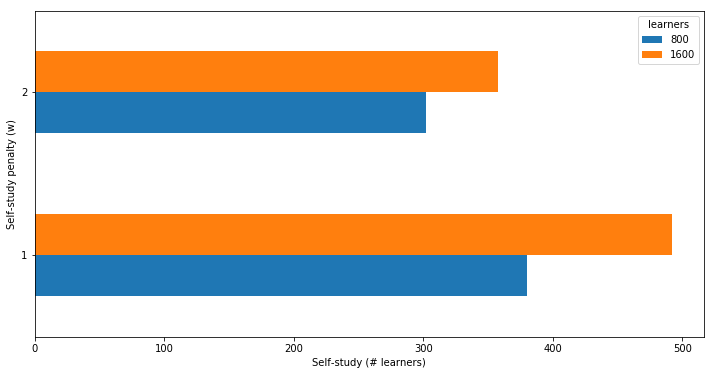

In [14]:
grouped = data.groupby(["learners", "penalty"])
grouped["self-study (# learners)"].mean().unstack(0).plot.barh(figsize=(12, 6))

plt.xlabel("Self-study (# learners)")
plt.ylabel("Self-study penalty (w)")

print(grouped["self-study (% learners)"].mean())
print(grouped["self-study (# learners)"].mean())

learners  first_degree
800       0.40           44.65
          0.50           41.95
          1.00           41.32
1600      0.40           28.50
          0.50           25.64
          1.00           25.56
Name: self-study (% learners), dtype: float64
learners  first_degree
800       0.40           357.18
          0.50           335.57
          1.00           330.58
1600      0.40           455.99
          0.50           410.24
          1.00           408.96
Name: self-study (# learners), dtype: float64


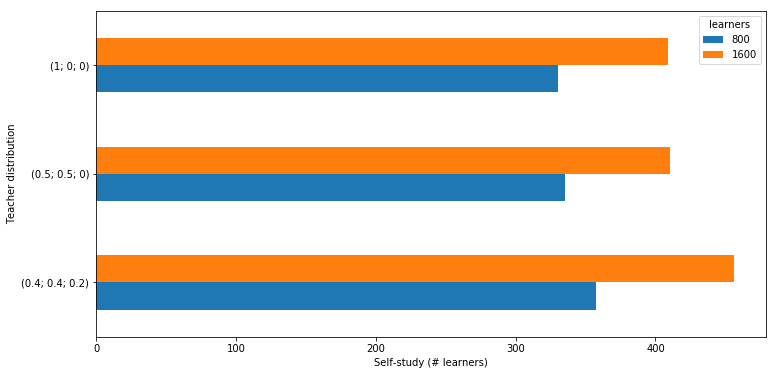

In [15]:
_, ax = plt.subplots()

grouped = data.groupby(["learners", "first_degree"])
grouped["self-study (# learners)"].mean().unstack(0).plot.barh(ax=ax, figsize=(12, 6))

ax.set_xlabel("Self-study (# learners)")
ax.set_ylabel("Teacher distribution")
ax.set_yticklabels(["(0.4; 0.4; 0.2)", "(0.5; 0.5; 0)",  "(1; 0; 0)"])

print(grouped["self-study (% learners)"].mean())
print(grouped["self-study (# learners)"].mean())

learners  instruction_size
800       16                 36.34
          32                 48.94
1600      16                 21.67
          32                 31.46
Name: self-study (% learners), dtype: float64
learners  instruction_size
800       16                 290.74
          32                 391.52
1600      16                 346.79
          32                 503.33
Name: self-study (# learners), dtype: float64


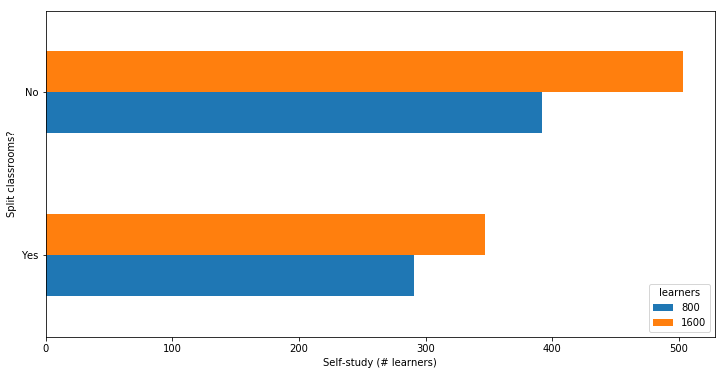

In [16]:
_, ax = plt.subplots()

grouped = data.groupby(["learners", "instruction_size"])
grouped["self-study (# learners)"].mean().unstack(0).plot.barh(ax=ax, figsize=(12, 6))

ax.set_xlabel("Self-study (# learners)")
ax.set_ylabel("Split classrooms?")
ax.set_yticklabels(["Yes", "No"])

print(grouped["self-study (% learners)"].mean())
print(grouped["self-study (# learners)"].mean())